In [1]:
import numpy as np
import os
import pandas as pd
import time
import math
import re
from itertools import groupby
from operator import itemgetter
# package for io 
from aicsimageio.writers import OmeTiffWriter
from aicsimageio.readers import tiff_reader, OmeTiffReader
from aicsimageio.readers.czi_reader import CziReader

import itertools
from skimage import measure as skmeasure
import datetime
from CustomFunctions import shparam_mod, metadata_funcs

from skimage.morphology import disk
from skimage.filters import median, gaussian


# load in some stuff to speed up processing
# (following https://sedeh.github.io/python-pandas-multiprocessing-workaround.html)
import multiprocessing

def collect_results(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.append(result)
    

def mygrouper(n, iterable):
    args = [iter(iterable)] * n
    return ([e for e in t if e != None] for t in itertools.zip_longest(*args))
    


def get_intensity_features(img, seg):
    features = {}
    input_seg = seg.copy()
    input_seg = (input_seg>0).astype(np.uint8)
    input_seg_lcc = skmeasure.label(input_seg)
    for mask, suffix in zip([input_seg, input_seg_lcc], ['', '_lcc']):
        values = img[mask>0].flatten()
        if values.size:
            features[f'intensity_mean{suffix}'] = values.mean()
            features[f'intensity_std{suffix}'] = values.std()
            features[f'intensity_1pct{suffix}'] = np.percentile(values, 1)
            features[f'intensity_99pct{suffix}'] = np.percentile(values, 99)
            features[f'intensity_max{suffix}'] = values.max()
            features[f'intensity_min{suffix}'] = values.min()
        else:
            features[f'intensity_mean{suffix}'] = np.nan
            features[f'intensity_std{suffix}'] = np.nan
            features[f'intensity_1pct{suffix}'] = np.nan
            features[f'intensity_99pct{suffix}'] = np.nan
            features[f'intensity_max{suffix}'] = np.nan
            features[f'intensity_min{suffix}'] = np.nan
    return features



def dist_f(a1, b1, c1, a2, b2, c2):

    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

# Function to find Angle
def angle_distance(a1, b1, c1, a2, b2, c2):
    a1,b1,c1 = [a1,b1,c1]/np.linalg.norm([a1,b1,c1])
    a2,b2,c2 = [a2,b2,c2]/np.linalg.norm([a2,b2,c2])
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

In [2]:
############################# RUN TRACKMATE TRACKING ON SEGMENTED IMAGES ##################################

In [5]:
croppeddir = 'G:/Cropped_LLS/'
# cell_list = [x for x in croppeddir]
'20240711_488_EGFP-CAAX_640_actin-halotag_01perDMSO_cell2-02-Subset-01'

cell_list = set([re.findall(r'(.*?_cell\d)', x)[0] for x in os.listdir(croppeddir)])
for i in cell_list:
    #get all of the images from a particular cell I was following
    curimlist = [x for x in os.listdir(croppeddir) if i in x]
    #find the total number of cells I cropped while following the cell of interest
    cellnums = set([re.findall(r'Subset-(\d+)',x)[0] for x in curimlist])
    for s in cellnums:
        #get all the images of a given cell
        curcell = [x for x in curimlist if f'Subset-{s}' in x]
        #sort the current cell to be in chronological order
        curcell.sort(key=lambda x: float(re.findall(r'(\d+)-Subset', x)[0]))
        time_elapsed = 0
        for n, c in enumerate(curcell):
            #open the image
            czi = CziReader(croppeddir + c)
            #open metadata
            root = metadata_funcs.getmdroot(czi)
            #absolute timepoint of first image
            if n == 0:
                timezero = metadata_funcs.adjustedstarttime(root)
            
            #get time interval and number of frames and start time
            ti = metadata_funcs.gettimeinterval(root)
            fn = metadata_funcs.framesinsubset(root)
            ast = metadata_funcs.adjustedstarttime(root)
            
            #loop through image frames
            for f in range(fn):
                #get the time at the current frame since the cell was initially observed
                frametime = int(ast - timezero + (f*ti))

            
            

20240524_488_EGFP-CAAX_640_actin-halotag_cell1-10-Subset-04_Frame1-11.czi 0
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-10-Subset-04_Frame1-11.czi 5
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-10-Subset-04_Frame1-11.czi 10
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-10-Subset-04_Frame1-11.czi 15
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-10-Subset-04_Frame1-11.czi 20
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-10-Subset-04_Frame1-11.czi 25
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-10-Subset-04_Frame1-11.czi 30
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-10-Subset-04_Frame1-11.czi 35
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-10-Subset-04_Frame1-11.czi 40
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-10-Subset-04_Frame1-11.czi 45
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-10-Subset-04_Frame1-11.czi 50
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-07-Subset-03_Frame1-17.czi 0
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-07-Subset-03_Frame1-17.czi 5
202

20240524_488_EGFP-CAAX_640_actin-halotag_cell1-03-Subset-01_Frame1-40.czi 514
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-03-Subset-01_Frame1-40.czi 519
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-03-Subset-01_Frame1-40.czi 524
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-03-Subset-01_Frame1-40.czi 529
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-03-Subset-01_Frame1-40.czi 534
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-03-Subset-01_Frame1-40.czi 539
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-03-Subset-01_Frame1-40.czi 544
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-03-Subset-01_Frame1-40.czi 549
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-03-Subset-01_Frame1-40.czi 554
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-03-Subset-01_Frame1-40.czi 559
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-03-Subset-01_Frame1-40.czi 564
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-03-Subset-01_Frame1-40.czi 569
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-03-Subset-01_Fram

20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01_Frame1-50.czi 1304
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01_Frame1-50.czi 1309
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01_Frame1-50.czi 1314
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01_Frame1-50.czi 1319
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01_Frame1-50.czi 1324
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01_Frame1-50.czi 1329
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01_Frame1-50.czi 1334
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01_Frame1-50.czi 1339
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01_Frame1-50.czi 1344
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01_Frame1-50.czi 1349
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01_Frame1-50.czi 1354
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Subset-01_Frame1-50.czi 1359
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-08-Su

20240524_488_EGFP-CAAX_640_actin-halotag_cell1-13-Subset-01_Frame1-30.czi 3143
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-13-Subset-01_Frame1-30.czi 3148
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-13-Subset-01_Frame1-30.czi 3153
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-13-Subset-01_Frame1-30.czi 3158
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-13-Subset-01_Frame1-30.czi 3163
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-13-Subset-01_Frame1-30.czi 3168
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-13-Subset-01_Frame1-30.czi 3173
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-13-Subset-01_Frame1-30.czi 3178
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-13-Subset-01_Frame1-30.czi 3183
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-13-Subset-01_Frame1-30.czi 3188
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-13-Subset-01_Frame1-30.czi 3193
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-13-Subset-01_Frame1-30.czi 3198
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-13-Su

20240524_488_EGFP-CAAX_640_actin-halotag_cell1-04-Subset-02_Frame1-28.czi 0
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-04-Subset-02_Frame1-28.czi 5
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-04-Subset-02_Frame1-28.czi 10
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-04-Subset-02_Frame1-28.czi 15
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-04-Subset-02_Frame1-28.czi 20
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-04-Subset-02_Frame1-28.czi 25
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-04-Subset-02_Frame1-28.czi 30
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-04-Subset-02_Frame1-28.czi 35
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-04-Subset-02_Frame1-28.czi 40
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-04-Subset-02_Frame1-28.czi 45
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-04-Subset-02_Frame1-28.czi 50
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-04-Subset-02_Frame1-28.czi 55
20240524_488_EGFP-CAAX_640_actin-halotag_cell1-04-Subset-02_Frame1-28.czi 60
2

20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-04_Frame1-62.czi 363
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-04_Frame1-62.czi 368
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-04_Frame1-62.czi 373
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-04_Frame1-62.czi 378
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-04_Frame1-62.czi 383
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-04_Frame1-62.czi 388
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-04_Frame1-62.czi 393
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-04_Frame1-62.czi 398
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-04_Frame1-62.czi 403
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-04_Frame1-62.czi 408
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-04_Frame1-62.czi 413
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-04_Frame1-62.czi 418
20240520_488_EGF

20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-03-Subset-01_Frame1-48.czi 290
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-03-Subset-01_Frame1-48.czi 295
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-03-Subset-01_Frame1-48.czi 300
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-03-Subset-01_Frame1-48.czi 305
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-03-Subset-01_Frame1-48.czi 310
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-03-Subset-01_Frame1-48.czi 315
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-03-Subset-01_Frame1-48.czi 320
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-03-Subset-01_Frame1-48.czi 325
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-03-Subset-01_Frame1-48.czi 330
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-03-Subset-01_Frame1-48.czi 335
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-03-Subset-01_Frame1-48.czi 340
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-03-Subset-01_Frame1-48.czi 345
20240520_488_EGF

20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-01_Frame1-106.czi 955
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-01_Frame1-106.czi 960
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-01_Frame1-106.czi 965
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-01_Frame1-106.czi 970
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-01_Frame1-106.czi 975
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-01_Frame1-106.czi 980
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-01_Frame1-106.czi 985
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-01_Frame1-106.czi 990
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-01_Frame1-106.czi 995
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-01_Frame1-106.czi 1000
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-01_Frame1-106.czi 1005
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-01_Frame1-106.czi 1010
2

20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01_Frame1-91.czi 1504
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01_Frame1-91.czi 1509
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01_Frame1-91.czi 1514
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01_Frame1-91.czi 1519
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01_Frame1-91.czi 1524
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01_Frame1-91.czi 1529
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01_Frame1-91.czi 1534
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01_Frame1-91.czi 1539
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01_Frame1-91.czi 1544
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01_Frame1-91.czi 1549
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01_Frame1-91.czi 1554
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-01_Frame1-91.czi 1559
2024

20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01_Frame1-69.czi 2175
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01_Frame1-69.czi 2180
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01_Frame1-69.czi 2185
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01_Frame1-69.czi 2190
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01_Frame1-69.czi 2195
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01_Frame1-69.czi 2200
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01_Frame1-69.czi 2205
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01_Frame1-69.czi 2210
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01_Frame1-69.czi 2215
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01_Frame1-69.czi 2220
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01_Frame1-69.czi 2225
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-09-Subset-01_Frame1-69.czi 2230
2024

20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01_Frame1-37.czi 3147
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01_Frame1-37.czi 3152
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01_Frame1-37.czi 3157
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01_Frame1-37.czi 3162
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01_Frame1-37.czi 3167
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01_Frame1-37.czi 3172
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01_Frame1-37.czi 3177
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01_Frame1-37.czi 3182
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01_Frame1-37.czi 3187
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01_Frame1-37.czi 3192
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01_Frame1-37.czi 3197
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-11-Subset-01_Frame1-37.czi 3202
2024

20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-06_Frame26-91.czi 184
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-06_Frame26-91.czi 189
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-06_Frame26-91.czi 194
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-06_Frame26-91.czi 199
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-06_Frame26-91.czi 204
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-06_Frame26-91.czi 209
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-06_Frame26-91.czi 214
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-06_Frame26-91.czi 219
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-06_Frame26-91.czi 224
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-06_Frame26-91.czi 229
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-06_Frame26-91.czi 234
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-06_Frame26-91.czi 239
2024

20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-05_Frame1-106.czi 80
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-05_Frame1-106.czi 85
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-05_Frame1-106.czi 90
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-05_Frame1-106.czi 95
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-05_Frame1-106.czi 100
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-05_Frame1-106.czi 105
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-05_Frame1-106.czi 110
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-05_Frame1-106.czi 115
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-05_Frame1-106.czi 120
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-05_Frame1-106.czi 125
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-05_Frame1-106.czi 130
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-06-Subset-05_Frame1-106.czi 135
20240520

20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-05_Frame1-47.czi 629
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-05_Frame1-47.czi 634
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-05_Frame1-47.czi 639
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-05_Frame1-47.czi 644
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-05_Frame1-47.czi 649
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-05_Frame1-47.czi 654
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-05_Frame1-47.czi 659
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-05_Frame1-47.czi 664
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-05_Frame1-47.czi 669
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-05_Frame1-47.czi 674
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-05_Frame1-47.czi 679
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-07-Subset-05_Frame1-47.czi 684
20240520_488_EGF

20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-10-Subset-08_Frame43-111.czi 0
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-10-Subset-08_Frame43-111.czi 5
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-10-Subset-08_Frame43-111.czi 10
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-10-Subset-08_Frame43-111.czi 15
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-10-Subset-08_Frame43-111.czi 20
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-10-Subset-08_Frame43-111.czi 25
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-10-Subset-08_Frame43-111.czi 30
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-10-Subset-08_Frame43-111.czi 35
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-10-Subset-08_Frame43-111.czi 40
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-10-Subset-08_Frame43-111.czi 45
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-10-Subset-08_Frame43-111.czi 50
20240520_488_EGFP-CAAX_561_mysoin-mApple_37C_cell2-10-Subset-08_Frame43-111.czi 55
202405

KeyboardInterrupt: 

In [3]:
ti, fn, ast

(5.0, '22', 75866)

In [4]:
from CustomFunctions.track_functions import segment_caax_tracks_confocal_40x_fromsingle

#### get together all images on the NAS #########

ip = 0.3394 #um / pixel .2285
step = 0.7 # um

#### directory info
bigdir = '//10.158.28.37/ExpansionHomesA/avlnas/HL60 ParaNitroBlebbistatin/'
foldlist = ['20240624','20240626','20240701']
savedir = 'E:/Aaron/ParaNitroBlebbistatin_37C/Tracking_Images/'

####  TZYX shape of the image
imshape = (181,150,1024,1024)

for f in foldlist:
    ims = [o for o in os.listdir(bigdir+f+'/')]
    for i in ims:
        #make the savedir if it doesn't exist
        if not os.path.exists(savedir+i+'/'):
            os.makedirs(savedir+i+'/')
        #directory of all the slices for this movie
        imdir = bigdir+f+'/'+i+'/Default/'
        
        
        ##### automatically detect image size
#         #sort the list of images and get the last one
#         last = sorted([o for o in os.listdir(imdir) if o.endswith('tif')])[-1]
#         #get stats about acquisition
#         cc,pos,maxtime,maxslices = [x for x in re.findall('\d*', last) if len(x)>1]
#         maxtime = int(maxtime)+1
#         maxslices = int(maxslices)+1
#         #open that image to get x,y size
#         shape = tiff_reader.TiffReader(imdir+last).shape
        
        results = []
        if __name__ ==  '__main__':
        # use multiprocessing to perform segmentation and x,y,z determination
            pool = multiprocessing.Pool(processes=60)
            for t in range(imshape[0]):
                pool.apply_async(segment_caax_tracks_confocal_40x_fromsingle, args=(imdir,
                                                                                    imshape[-3:],
                                                                                    ip,
                                                                                    step,
                                                                                    t, ), 
                                 callback=collect_results)
            pool.close()
            pool.join()
            


        #organize the semented frames into a segmented stack
        segmented_img = np.zeros((imshape[0],
                                 results[0][3][-3],
                                 results[0][3][-2],
                                 results[0][3][-1]))
        for r in results:
            fr = r[2]
            segmented_img[fr,:,:,:] = r[1]    

        #covert to more compact data type
        segmented_img = segmented_img.astype(np.uint8)

        #save the segmented image
        OmeTiffWriter.save(segmented_img, savedir+i+'/'+i+'_segmented.ome.tiff', dim_order = "TZYX", overwrite_file=True)


        #save the skimage region props
        df = pd.DataFrame()
        for d in results:
            df = df.append(pd.DataFrame(d[0], columns = ['cell', 
                         'frame', 'z_min', 'y_min', 
                        'x_min','z_max', 'y_max', 'x_max',
                       'z', 'y', 'x', 'z_range',
                       'area', 'convex_area', 'extent',
                       'minor_axis_length', 'major_axis_length',
                        'intensity_avg', 'intensity_max', 'intensity_std']))
        df = df.sort_values(by = ['frame','cell'])
        df.to_csv(savedir+i+'/'+i+'_region_props.csv')
        
        print(f'Finished processing {i}')

Finished processing 20240624_488EGFP-CAAX_01perDMSO_37C_1
Finished processing 20240624_488EGFP-CAAX_01perDMSO_37C_2
Finished processing 20240624_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1
Finished processing 20240624_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2
Finished processing 20240626_488EGFP-CAAX_01perDMSO_37C_1
Finished processing 20240626_488EGFP-CAAX_01perDMSO_37C_2
Finished processing 20240626_488EGFP-CAAX_01perDMSO_37C_3
Finished processing 20240626_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1
Finished processing 20240626_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2
Finished processing 20240701_488EGFP-CAAX_01perDMSO_37C_1
Finished processing 20240701_488EGFP-CAAX_01perDMSO_37C_2
Finished processing 20240701_488EGFP-CAAX_01perDMSO_37C_3
Finished processing 20240701_488EGFP-CAAX_01perDMSO_37C_4
Finished processing 20240701_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_1
Finished processing 20240701_488EGFP-CAAX_10uMParaNitroBlebbistatin_37C_2


In [ ]:
############### SEGMENT AND SAVE CELLS ################################

############## alignment by chemical gradient ###################

from scipy.spatial import KDTree, distance
from itertools import groupby
from operator import itemgetter
from scipy import interpolate
import re
from aicsimageio.readers.bioformats_reader import BioformatsReader

#import the cell segmentation and rotation function
# import sys
# # insert at 1, 0 is the script path (or '' in REPL)
# import_path = 'C:/Users/Aaron/Documents/PythonScripts/CustomFunctions'
# sys.path.insert(1, import_path)
from CustomFunctions.segment_cells2short import seg_confocal_40x_memonly_fromslices

from CustomFunctions.persistance_activity import get_pa, velocity_and_distance, DA_3D


# path to folder(s)
base = 'E:/Aaron/ParaNitroBlebbistatin_37C/'
folder_fl = base + 'Tracking_Images/'
filelist_fl = [f for f in os.listdir(folder_fl)]
savedir = base + 'Processed_Data/'
datadir = base + 'Data_and_Figs/'
#make the savedir if it doesn't exist
if not os.path.exists(savedir):
    os.makedirs(savedir)
if not os.path.exists(datadir):
    os.makedirs(datadir)
raw_dir = '//10.158.28.37/ExpansionHomesA/avlnas/HL60 ParaNitroBlebbistatin/'

#parameters for segmentation
xy_buffer = 20 #pixels
z_buffer = 10 #pixels
xyres = 0.3394 #um / pixel 
zstep = 0.7 # um
interval = 10
intthresh = 120 #for the half shrunken images, determined by manually crossreferencing
imshape = (150,1024,1024)


###list to append cell info dicts
allcellinfo = []

# u = filelist_fl[0]


for u in filelist_fl:

    ################## align trackmate data with region props data ################
    rpcsv = [x for x in os.listdir(folder_fl + u) if x.endswith("region_props.csv")][0]
    rp = pd.read_csv(folder_fl + u + '/' + rpcsv, index_col = 0)
    tmcsv = [x for x in os.listdir(folder_fl + u) if x.endswith("TrackMateLog.csv")][0]
    tm = pd.read_csv(folder_fl + u+ '/' + tmcsv)
    #fix trackmate columns to get names right and units in microns
    tm['x'] = tm.POSITION_X*xyres
    tm['y'] = tm.POSITION_Y*xyres
    tm['z'] = tm.POSITION_Z*zstep
    #make kdtree and query with trackmate log
    kd = KDTree(rp[['frame','x','y','z']].to_numpy())
    dd, ii = kd.query(tm[['FRAME','x','y','z']])
    df_track = pd.concat([tm.drop(columns=['POSITION_X','POSITION_Y','POSITION_Z']), 
                        rp.iloc[ii].drop(columns=['frame','x','y','z', 'cell']).reset_index(drop=True)], axis=1)
    df_track = df_track.rename(columns={'TRACK_ID':'cell', 'FRAME':'frame'})
    #sort by cell and frame
    df_track = df_track.sort_values(['cell','frame'])



    #############find distance travelled##################
    longdistmatrix = distance.pdist(df_track[['x','y','z']])
    shortdistmatrix = distance.squareform(longdistmatrix)
    shortdistmatrix = np.array(shortdistmatrix)
    dist = pd.Series([], dtype = 'float64')
    for count, i in enumerate(shortdistmatrix):
        if count == 0:
            temp = pd.Series([0])
            dist = dist.append(temp, ignore_index=True)
        else:
            temp = pd.Series(shortdistmatrix[count,count-1])
            dist = dist.append(temp, ignore_index=True)
    df_track = df_track.reset_index(drop = True)
    df_track['dist'] = dist
#     #first rows that have super long distances from previous cell, so set them to 0
#     df_track.loc[df_track.groupby('cell').head(1).index,'dist'] = 0

    ############ replace unrealistic jumps in distance ##############
    for x in df_track[df_track.dist>4].index.values:
        df_track['dist'][x] = df_track.dist.mean()

    ############## find euclidean distance #############
    euclid = pd.DataFrame([])
    for i, cell in df_track.groupby('cell'):
        FL = cell.iloc[[0,-1]]
        euc_dist = distance.pdist(FL[['x','y','z']])
        euclid = euclid.append({'cell':cell.cell.iloc[0], 'euc_dist':euc_dist[0]}, ignore_index = True)
    cellsmorethan = euclid.loc[euclid['euc_dist']>10, 'cell']
    df_track = df_track[df_track.cell.isin(cellsmorethan)]

    #     ########remove "slow"/dead cells############
    #     #sum distances
    #     df_track_distsums = df_track.groupby('cell').sum()
    #     df_track_distsums = df_track_distsums.add_suffix('_sum').reset_index()

    #     #grab only cells with sums above a threshold distance
    #     cellsmorethan = df_track_distsums.loc[df_track_distsums['dist_sum']>5, 'cell']
    #     df_track = df_track[df_track.cell.isin(cellsmorethan)]


    ########remove edge cells############
    #only grab rows that aren't zero in z_min
    df_track = df_track.loc[df_track['x_min'] !=0 ]
    df_track = df_track.loc[df_track['y_min'] !=0 ]
    df_track = df_track.loc[df_track['z_min'] !=0 ]
    #remove rows where z_max matches z_range
    df_track = df_track.loc[df_track['x_max'] < imshape[-1]]
    df_track = df_track.loc[df_track['y_max'] < imshape[-2]]
    df_track = df_track.loc[df_track['z_max'] != (df_track['z_range'])]
    
    
    ##########remove small things that are likely dead cells or parts of cells###########
    df_track = df_track[df_track['area'] > 4000 ]


    #reset index after dropping all the rows
    df_track = df_track.reset_index(drop = True)



    ######## remove cells that touch ###########    
    to_remove = []
    for i, cell in df_track.groupby('cell'):
        if i>0:
            changes = abs(cell['convex_area'].pct_change())
            largerthan = changes[changes>0.75]
            if largerthan.empty == False:
                to_remove.extend(largerthan.index.to_list())


            # changes = cell['convex_area'].diff()
            # largerthan = changes[changes>cell['convex_area']*0.333]
            # smallerthan = changes[changes<cell['convex_area']*-0.333]
            # print(largerthan.index,smallerthan.index)
            # #remove all frames of a cell after it contacts another cell
            # if largerthan.empty == False:
            #     for n in largerthan.index:
            #         to_remove.append(list(range(n, max(cell.index)+1)))
            # #remove all frames of a cell before it splits from another cell
            # if smallerthan.empty == False:
            #     for n in smallerthan.index:
            #         to_remove.append(list(range(cell.index[0], n-1)))
    # #remove duplicate indicies
    # to_remove = [j for x in to_remove for j in x]
    # to_remove = list(set(to_remove))
    #drop touching or splitting cells
    df_track = df_track.drop(to_remove)



    if df_track.empty == False:
        for i, cells in df_track.groupby('cell'):
            cells = cells.reset_index(drop = True)
            runs = list()
            #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
            for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
                currentrun = list(map(itemgetter(1), g))
                list.append(runs, currentrun)
            for r in runs:
                r = np.array(r, dtype=int)
                #skip runs less than 3 frames long
                if len(r)<3:
                    pass
                else:
                    cell = cells.iloc[[cells[cells.frame==y].index[0] for y in r]]
                    #segment the cell channel and get centroid
                    df = pd.DataFrame()
                    if __name__ ==  '__main__':
                        # use multiprocessing to perform segmentation and x,y,z determination
                        pool = multiprocessing.Pool(processes=60)
                        results = []
                        for t, row in cell.iterrows():
                            
                            tdir = raw_dir +u.split('_')[0]+'/' +u+'/Default/'
                            
                            xmincrop = int(max(0, row.x_min-xy_buffer))
                            ymincrop = int(max(0, row.y_min-xy_buffer))
                            zmincrop = int(max(0, row.z_min-z_buffer))

                            zmaxcrop = int(min(row.z_max+z_buffer, imshape[-3]))
                            ymaxcrop = int(min(row.y_max+xy_buffer, imshape[-2])+1)
                            xmaxcrop = int(min(row.x_max+xy_buffer, imshape[-1])+1)
                            
                            pool.apply_async(seg_confocal_40x_memonly_fromslices, args = (
                                tdir,
                                imshape,
                                row,
                                u,
                                savedir,
                                xyres,
                                zstep,
                                xmincrop, 
                                ymincrop, 
                                zmincrop,
                                xmaxcrop, 
                                ymaxcrop, 
                                zmaxcrop,
                                ),             
                                callback = collect_results)

                        pool.close()
                        pool.join()

                        print(f'Done segmenting {u} cell {cell.cell.iloc[0]}')

                    if any([x == None for x in results]):
                        ind = results.index(None)
                        if len(results[:ind])<3:
                            pass
                        else:
                            results = results[:ind]

                    #aggregate the dataframe
                    for d in results:
                        df = df.append(pd.DataFrame(d, columns = d.keys(), index=[0]))
                    df = df.sort_values(by = 'frame').reset_index(drop=True)



                    #make sure there are no gaps due to failed segmentations
                    if any(df.frame.diff()>1):
                        dft = df.reset_index(drop = True)
                        runs = list()
                        #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
                        for k, g in groupby(enumerate(dft['frame']), lambda ix: ix[0] - ix[1]):
                            currentrun = list(map(itemgetter(1), g))
                            list.append(runs, currentrun)
                        whichframes = np.array(max(runs, key=len), dtype=int)
                        pullrows = dft[dft.frame.isin(whichframes)]
                        df = pullrows.copy().reset_index(drop=True)





#                     ################ Signal velocities and distance travelled ###############
#                     isvs, sds, tds, eds = velocity_and_distance(df, interval, )
#                     df['Instant_Signal_Velocity'] = np.concatenate([np.array([np.nan]), np.array(isvs)])
#                     df['Signal_Velocity'] = np.concatenate([np.array([np.nan]), sds])
#                     df['Total_Distance_Travelled'] = np.concatenate([np.array([np.nan]), tds])
#                     df['Euclidean_Distance_Travelled'] = np.concatenate([np.array([np.nan]), eds])


                    #set the k order for interpolation to the max possible
                    if len(df)<6:
                        kay = len(df)-1
                    else:
                        kay = 5

                    #     seg_nucleus[t,:,:,:] = segment_nucleus(temp_im[t,1,:,:,:])
                    pos = df[['x','y','z']]
                    if bool(pos[pos.duplicated()].index.tolist()):
                        ######### FIND CELL TRAJECTORY AND EULER ANGLES ################
                        # if there is duplicate positions
                        dups = pos[pos.duplicated()].index.tolist()
                        pos_drop = pos.drop(dups, axis = 0)
                        if pos_drop.shape[0]<3:
                            traj = np.zeros([1,2,3])
                        else:
                            #get trajectories without the duplicates
                            tck, u = interpolate.splprep(pos_drop.to_numpy().T, k=kay, s=5)
                            yderv = interpolate.splev(u,tck,der=1)
                            traj = np.vstack(yderv).T
                            #get smoothened trajectory
                            ysmo = interpolate.splev(u,tck,der=0)
                            trajsmo = np.vstack(ysmo).T
                            #re-insert duplicate row that was dropped
                            for d, dd in enumerate(dups):
                                traj = np.insert(traj, dd, traj[dd-1,:], axis=0)
                                trajsmo = np.insert(trajsmo, dd, trajsmo[dd-1,:], axis=0)

                    else:
                        ######### FIND CELL TRAJECTORY AND EULER ANGLES ################
                        #no duplicate positions
                        #interpolate and get tangent at midpoint
                        tck, b = interpolate.splprep(pos.to_numpy().T, k=kay, s=5)
                        yderv = interpolate.splev(b,tck,der=1)
                        traj = np.vstack(yderv).T
                        #get smoothened trajectory
                        ysmo = interpolate.splev(b,tck,der=0)
                        trajsmo = np.vstack(ysmo).T
                    
                    ###add smoothened trajectory positions 
                    #change x y z names in the dataframe
                    df.rename(columns={"x": "x_raw", "y": "y_raw", "z": "z_raw"})
                    #add smoothened positions
                    df['x'] = trajsmo[:,0]
                    df['y'] = trajsmo[:,1]
                    df['z'] = trajsmo[:,2]
                    
                    ############## Bayesian persistence and activity #################
                    persistence, activity, speed = get_pa(df, interval)
                    df['persistence'] = np.concatenate([np.array([np.nan]*2), persistence])
                    df['activity'] = np.concatenate([np.array([np.nan]*2), activity])
                    df['speed'] = np.concatenate([np.array([np.nan]), speed])
                    df['avg_persistence'] = np.array([persistence.mean()]*(len(persistence)+2))
                    df['avg_activity'] = np.array([activity.mean()]*(len(activity)+2))
                    df['avg_speed'] = np.array([speed.mean()]*(len(speed)+1))
                    
                    #add directional autocorrelations
                    df['directional_autocorrelation'] = DA_3D(df[['x','y','z']].to_numpy())
                    
                    #get the trajectory and the previous trajectory for each frame and 
                    #save as an individual dataframe for each cell and frame
                    for v, row in df.iterrows():
                        row = df.loc[v]
                        if v==0:
                            row['Prev_Trajectory_X'] = np.nan
                            row['Prev_Trajectory_Y'] = np.nan
                            row['Prev_Trajectory_Z'] = np.nan
                            row['Trajectory_X'] = traj[v,0]
                            row['Trajectory_Y'] = traj[v,1]
                            row['Trajectory_Z'] = traj[v,2]
                            row['Turn_Angle'] = np.nan
#                             pd.DataFrame(row.to_dict(),index=[0]).to_csv(savedir + row.cell + '_cell_info.csv')
                            allcellinfo.append(row)
                        if v>0:
                            row['Prev_Trajectory_X'] = traj[v-1,0]
                            row['Prev_Trajectory_Y'] = traj[v-1,1]
                            row['Prev_Trajectory_Z'] = traj[v-1,2]
                            row['Trajectory_X'] = traj[v,0]
                            row['Trajectory_Y'] = traj[v,1]
                            row['Trajectory_Z'] = traj[v,2]
                            row['Turn_Angle'] = angle_distance(traj[v-1,0], traj[v-1,1], traj[v-1,2], traj[v,0], traj[v,1], traj[v,2])
#                             pd.DataFrame(row.to_dict(),index=[0]).to_csv(savedir + row.cell + '_cell_info.csv')
                            allcellinfo.append(row)
allcellinfo = pd.DataFrame(allcellinfo)
allcellinfo.to_csv(datadir + 'All_Cell_Tracking_Info.csv')

C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done segmenting 20240624_488EGFP-CAAX_01perDMSO_37C_1 cell 0


C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


Done segmenting 20240624_488EGFP-CAAX_01perDMSO_37C_1 cell 0
Done segmenting 20240624_488EGFP-CAAX_01perDMSO_37C_1 cell 6
Done segmenting 20240624_488EGFP-CAAX_01perDMSO_37C_1 cell 6
Done segmenting 20240624_488EGFP-CAAX_01perDMSO_37C_1 cell 6
Done segmenting 20240624_488EGFP-CAAX_01perDMSO_37C_1 cell 6
Done segmenting 20240624_488EGFP-CAAX_01perDMSO_37C_1 cell 8
Done segmenting 20240624_488EGFP-CAAX_01perDMSO_37C_1 cell 8
Done segmenting 20240624_488EGFP-CAAX_01perDMSO_37C_1 cell 8
Done segmenting 20240624_488EGFP-CAAX_01perDMSO_37C_1 cell 8
Done segmenting 20240624_488EGFP-CAAX_01perDMSO_37C_1 cell 12
Done segmenting 20240624_488EGFP-CAAX_01perDMSO_37C_1 cell 13
Done segmenting 20240624_488EGFP-CAAX_01perDMSO_37C_1 cell 13
Done segmenting 20240624_488EGFP-CAAX_01perDMSO_37C_1 cell 14
Done segmenting 20240624_488EGFP-CAAX_01perDMSO_37C_1 cell 14
Done segmenting 20240624_488EGFP-CAAX_01perDMSO_37C_1 cell 14
Done segmenting 20240624_488EGFP-CAAX_01perDMSO_37C_1 cell 14
Done segmenting 2

In [6]:
############ FIND WIDTH ROTATIONS THAT DEPEND ON PREVIOUS FRAMES TO LIMIT ROTATION FLIPPING ################

mindir = 'E:/Aaron/ParaNitroBlebbistatin_37C/'
savedir = mindir + 'Processed_Data/'
datadir = mindir + 'Data_and_Figs/'


xyres = 0.3394 #um / pixel 
zstep = 0.7 # um
align_method = 'trajectory'
sigma = 0

imlist = []
for o in os.listdir(savedir):
    if 'segmented' in o:
        cellid = o.split('_frame')[0]
        if cellid not in imlist:
            imlist.append(cellid)
            
allresults = []
for i in imlist:
    if __name__ ==  '__main__':
        results = []
        pool = multiprocessing.Pool(processes=60)
        for j in os.listdir(savedir):
            if (i+'_' in j) and ('segmented' in j):
                #get path to segmented image
                impath = savedir + j
    
                #put in the pool
                pool.apply_async(shparam_mod.find_normal_width_peaks, args = (
                    impath,
                    xyres,
                    zstep,
                    sigma,
                    align_method,
                    ),             
                    callback = collect_results)
    
        pool.close()
        pool.join()
    
    results.sort(key=lambda x: float(re.findall('(?<=frame_)\d*', x[0])[0]))
    tempframe = pd.DataFrame(results, columns = ['cell','Width_Peaks'])
    tempframe['frame'] = [float(re.findall('(?<=frame_)\d*', x[0])[0]) for x in results]
    
    runs = list()
    #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
    for k, g in groupby(enumerate(tempframe['frame']), lambda ix: ix[0] - ix[1]):
        currentrun = list(map(itemgetter(1), g))
        list.append(runs, currentrun)

    
    #find the minima in each frame that are closest to the minimum chosen in the last frame
    #aka the one that results in the least amount of consecutive rotation
    fullminlist = []
    for xx in runs:
        runframe = tempframe[tempframe.frame.isin(xx)]
        wplist = runframe.Width_Peaks.to_list()
        seeds = []
        allallmins = []
        #for all the starting peaks find the least different rotations through time
        for s in wplist[0]:
            allmins = [s]
            for wp in wplist[1:]:
                if bool(len(wp) == 0):
                    allmins.append(allmins[-1])
                else:
                    allmins.append(wp[np.argmin(abs(wp-(allmins[-1])))])
            allallmins.append(allmins)
            seeds.append(np.sum(abs(np.diff(allmins))))
        #add rotations of current run to the list
        fullminlist.extend(allallmins[np.argmin(seeds)])  
    
    
    #add all mins to tempframe
    tempframe['Closest_minimums'] = fullminlist
    
    allresults.append(tempframe)
    
    print('Finished '+ i)

#save the shape metrics dataframe
bigdf = pd.concat(allresults)
bigdf.to_csv(datadir + 'Closest_Width_Peaks.csv')


Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_0
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_12
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_13
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_14
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_16
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_22
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_24
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_31
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_40
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_41
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_42
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_43
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_45
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_63
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_65
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_6
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_1_cell_8
Finished 20240624_488EGFP-CAAX_01perDMSO_37C_2_cell_0
Finished 20240

Finished 20240701_488EGFP-CAAX_01perDMSO_37C_3_cell_7
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_10
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_11
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_12
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_13
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_15
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_1
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_22
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_27
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_31
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_32
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_33
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_4
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_5
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_6
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_7
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_8
Finished 20240701_488EGFP-CAAX_01perDMSO_37C_4_cell_9
Finished 20240701_

In [7]:
############## GET SURFACE MESHES AND OTHER SHAPE STATS ##############


savedir = 'E:/Aaron/ParaNitroBlebbistatin_37C/Processed_Data/'


#make dirs if it doesn't exist
datadir = 'E:/Aaron/ParaNitroBlebbistatin_37C/Data_and_Figs/'
if not os.path.exists(datadir):
    os.makedirs(datadir)
meshf = savedir+'Meshes/'  
if not os.path.exists(meshf):
    os.makedirs(meshf)
pilrf = savedir+'PILRs/'
if not os.path.exists(pilrf):
    os.makedirs(pilrf)

    

xyres = 0.3394 #um / pixel 
zstep = 0.7 # um
align_method = 'trajectory'
norm_rot = 'provided'
l_order = 10
nisos = [1,63]
sigma = 0
errorlist = []


if norm_rot == 'provided':
    widthpeaks = pd.read_csv(datadir + 'Closest_Width_Peaks.csv', index_col = 0)
    
#get all segmented images
imlist = [x for x in os.listdir(savedir) if x.endswith('segmented.tiff')]

start = 0
stop = 300
allresults = []
while start<len(imlist):
    print(f'Finished {start}, starting {start}-{stop}')
    if __name__ ==  '__main__':
        results = []
        pool = multiprocessing.Pool(processes=60)
        for i in imlist[start:stop]:
            #get path to segmented image
            impath = savedir + i
            
            #choose structure name based on file name
            if 'actin' in impath:
                str_name = 'actin'
            elif ('Hoechst' in impath) or ('DNA' in impath):
                str_name = 'nucleus'
            elif 'myosin' in impath:
                str_name = 'myosin'
            else:
                str_name = ''
            
            #assign the normal rotation value for that particular cell
            if (norm_rot == 'provided') or (type(norm_rot) == float):
                norm_rot = float(widthpeaks[widthpeaks.cell == i.split('_segment')[0]]['Closest_minimums'].values[0])
                
            #put in the pool
            pool.apply_async(shparam_mod.shcoeffs_and_PILR_nonuc, args = (
                impath,
                savedir,
                xyres,
                zstep,
                str_name,
                errorlist,
                norm_rot,
                l_order,
                nisos,
                sigma,
                align_method,
                ),             
                callback = collect_results)

        pool.close()
        pool.join()
    
    allresults.extend(results)
    
    start = stop + 1
    stop = stop + 1000
    if stop>len(imlist):
        stop = len(imlist)

errorlist = []
bigdf = pd.DataFrame()

for r in allresults:
    

    Shape_Stats = pd.DataFrame([r[0].values()],
                                  columns = list(r[0].keys()))
    cell_coeffs = pd.DataFrame([r[1].values()],
                               columns = list(r[1].keys()))

    bigdf = bigdf.append(pd.concat([Shape_Stats,cell_coeffs], axis=1))

    errorlist.extend(r[2])


#save the shape metrics dataframe
bigdf = bigdf.set_index('cell')
bigdf.to_csv(datadir + 'Shape_Metrics.csv')

#save list of cells that don't have centroid in shape
pd.Series(errorlist).to_csv(datadir + 'ListToExclude.csv')

Finished 0, starting 0-300
Finished 301, starting 301-1300
Finished 1301, starting 1301-2300
Finished 2301, starting 2301-3300
Finished 3301, starting 3301-4300
Finished 4301, starting 4301-5300
Finished 5301, starting 5301-6300
Finished 6301, starting 6301-7300
Finished 7301, starting 7301-8300
Finished 8301, starting 8301-9300
Finished 9301, starting 9301-10300
Finished 10301, starting 10301-11300
Finished 11301, starting 11301-12300
Finished 12301, starting 12301-13300
Finished 13301, starting 13301-14300
Finished 14301, starting 14301-15300
Finished 15301, starting 15301-16300
Finished 16301, starting 16301-17300
Finished 17301, starting 17301-18300
Finished 18301, starting 18301-19300
Finished 19301, starting 19301-20248


C:\ProgramData\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


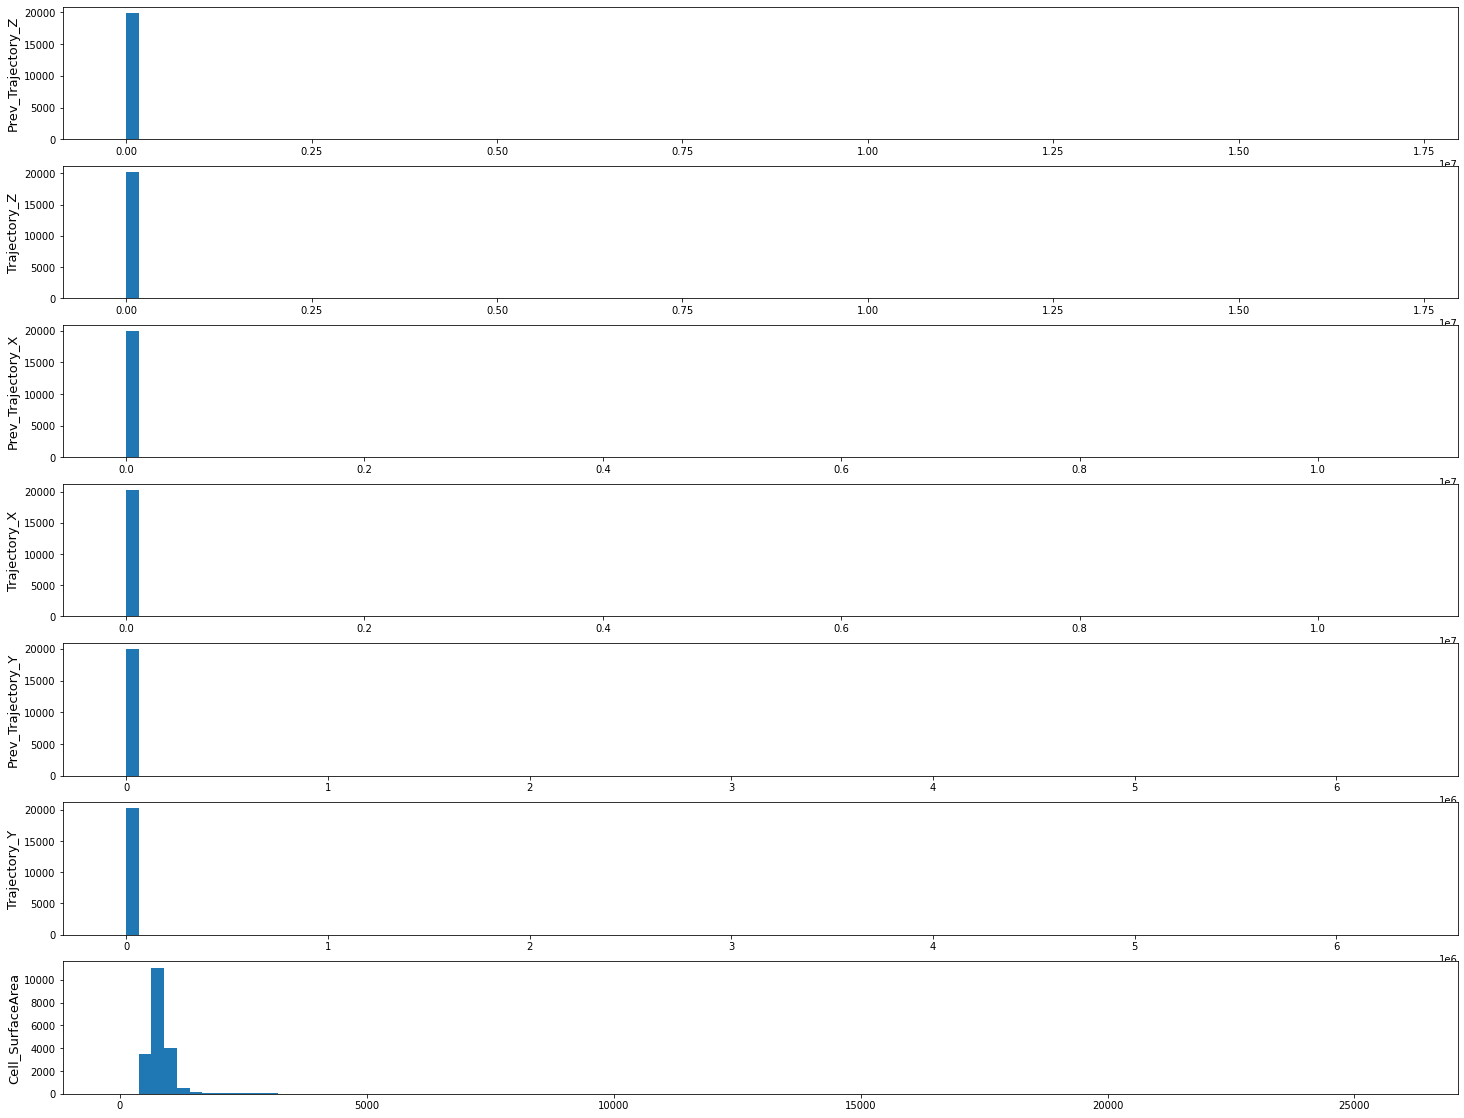

In [2]:
#################### Check shape distributions for extreme outliers before PCA ####################
import matplotlib.pyplot as plt
from CustomFunctions.file_management import multicsv
folder_fl = 'E:/Aaron/ParaNitroBlebbistatin_37C/'
data_fl = folder_fl + 'Data_and_Figs/'
info_fl = folder_fl + 'Processed_Data/'

#open full dataframe
df = pd.read_csv(data_fl + 'Shape_Metrics.csv')

excludes = pd.read_csv(data_fl + 'ListToExclude.csv', index_col=0)
exlist = [i.replace('_segmented.tiff', '') for i in excludes.iloc[:,0].to_list()]
df = df.loc[[x for x in df.index if x not in exlist]]

#add all of the other metrics from the single csv files
if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=60)
    csvlist = [info_fl + i +'_cell_info.csv' for i in df.cell.to_list()]
    celllist = pool.map(multicsv, csvlist)
    pool.close()
    pool.join()
cellinfo = pd.concat(celllist)
# Add distance travelled per framerate to total frame
df = df.merge(cellinfo.drop(columns=['image', 'cropx (pixels)',
       'cropy (pixels)', 'cropz (pixels)']), left_on = 'cell', right_on = 'cell')

metrics = df.std().sort_values(ascending = False).index[:7]
# df = df[(df.Cell_Volume < 2070) & (df.Cell_Volume > 498)]
# df = df[df.Cell_SurfaceArea < 1800]
fig, axes = plt.subplots(len(metrics), 1, figsize=(25,20))#, sharex=True)
for i, ax in enumerate(axes):
    ax.hist(abs(df[metrics[i]]), 100) #, 30, (-2,2))
    ax.set_ylabel(metrics[i], fontsize = 13)
# #volume threshold determined by looking through cropped cell images
newdf = df[(df.Cell_Volume < 2070) & (df.Cell_Volume > 498)].copy()
newdf = newdf[(newdf.Cell_SurfaceArea < 1800) & (newdf.Cell_SurfaceArea > 500)]

newdf.to_csv(data_fl + 'Shape_Metrics_outliersremoved.csv')

In [15]:
df.Cell_Volume.sort_values(ascending=False).head(250)
# df.Cell_Volume.std()*3.5

cell
20231019_488EGFP-CAAX_2_cell_0_frame_125      41171.824758
20231019_488EGFP-CAAX_2_cell_0_frame_126      39045.207103
20231019_488EGFP-CAAX_1_cell_32_frame_303     35755.608704
20231020_488EGFP-CAAX_1_cell_61_frame_231     34064.992314
20231020_488EGFP-CAAX_1_cell_11_frame_136     33175.861057
                                                  ...     
20231019_488EGFP-CAAX_1_cell_99_frame_218      2479.344193
20231019_488EGFP-CAAX_1_cell_115_frame_351     2470.686063
20231019_488EGFP-CAAX_1_cell_140_frame_319     2467.212039
20231020_488EGFP-CAAX_1_cell_129_frame_280     2458.164162
20231019_488EGFP-CAAX_1_cell_140_frame_293     2456.941206
Name: Cell_Volume, Length: 250, dtype: float64